In [1]:
import os
import sys
import warnings

from glob import glob
import random
import datetime
import re
from tqdm import tqdm

import pandas as pd
import numpy as np

from google.cloud import bigquery

import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

import gspread
from oauth2client.service_account import ServiceAccountCredentials


from plotnine import *

warnings.filterwarnings('ignore')

In [2]:
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
font = fm.FontProperties(fname=path, size=9)

NanumGothic


In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', -1)
pd.options.display.float_format = '{:.2f}'.format

In [4]:
def bigquery_to_pandas(query_string) :

    credential_path = '../99_credential/lawtalk-bigquery-2bfd97cf0729.json'
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credential_path
    bqclient = bigquery.Client()
    
    b = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(
            # Optionally, explicitly request to use the BigQuery Storage API. As of
            # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
            # API is used by default.
            create_bqstorage_client=True,
        )
    )
    
    return b

def read_bql(file_name) :
    with open(file_name, "r") as f :
        bql = f.read()
    return bql


def gs_append(url, credential_path = '../99_credential/lawtalk-bigquery-2bfd97cf0729.json', scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']) : 
    
    credentials = ServiceAccountCredentials.from_json_keyfile_name(credential_path, scope)
    
    gc = gspread.authorize(credentials)
    doc = gc.open_by_url(url)
    
    sheet_name = re.search(string = str(doc.get_worksheet(0)), pattern = r"\'(.*)\'").group(0)[1:-1]
    sheet = doc.worksheet(sheet_name)
    
    sheet_content = sheet.get_all_values()
    
    df_ = pd.DataFrame(sheet_content[1:], columns = sheet_content[0])
    
    return df_

In [5]:
before_review = bigquery_to_pandas(read_bql("../bql/review_cnt.bql").format("2022-04-01"))
after_review = bigquery_to_pandas(read_bql("../bql/review_cnt.bql").format("2022-07-03"))

advice_cloud = bigquery_to_pandas(read_bql("../bql/cloud_history.bql"))
advice_cloud = advice_cloud[advice_cloud.slug.notna()]
advice_cloud.visibleCloudType = advice_cloud.visibleCloudType.fillna("normal")

before = advice_cloud[advice_cloud.createdAt.dt.date.isin(pd.date_range(datetime.datetime(2022, 4, 1), datetime.datetime(2022, 5, 1)).date)]
after = advice_cloud[advice_cloud.createdAt.dt.date >= datetime.date(2022, 7, 3)]

before = pd.merge(before, before_review, on = ["lawyer", "slug"], how = "left")
after = pd.merge(after, after_review, on = ["lawyer", "slug"], how = "left")

before.review_cnt = before.review_cnt.fillna(0)
after.review_cnt = after.review_cnt.fillna(0)

In [6]:
gafter = after.groupby(["slug", "visibleCloudType"]).agg(days = ("createdAt", lambda x : max(x) - min(x)), min_date = ("createdAt", min)).assign(days = lambda x : x.days.dt.days).reset_index()
gafter = gafter.assign(tf = lambda x : np.where(x.days > 30, "t", "f"))

- 배포(5월) 전(4월 기준) 데이터와 데이터가 쌓인 7/2일 이후(7/3~) 후기뷰 변경 및 유지를 30일 이상 경과한 변호사 추출

In [7]:
after = pd.merge(after, gafter[["slug", "visibleCloudType", "tf"]], on = ["slug", "visibleCloudType"])
after = after[after.tf == 't']
after["days_from_min"] = after.groupby(["slug", "visibleCloudType"]).createdAt.transform(lambda x : x - min(x)).dt.days
after = after[(after.days_from_min < 30)]

### 후기뷰 배포 전/후에 대한 상관관계
- 상관계수의 종류에 따라 조금 편차가 있으나 거의 비슷한 것으로 보임.

- pearson
    - 연속형 변수 간 선형 상관관계를 확인할 때 가장 흔하게 쓰이나, 두 변수가 정규성을 따른다는 가정이 필요

In [8]:
before.groupby(["visibleCloudType", "slug", "review_cnt"])._id.count().reset_index().corr()

,review_cnt,_id
review_cnt,1.00,0.64
_id,0.64,1.00


In [9]:
after.groupby(["visibleCloudType", "slug", "review_cnt"])._id.count().reset_index().corr()

,review_cnt,_id
review_cnt,1.00,0.71
_id,0.71,1.00


- spearman
    - 정규성을 따르지 않아도 사용할 수 있으며, 순위형 변수에도 적용 가능

In [10]:
before.groupby(["visibleCloudType", "slug", "review_cnt"])._id.count().reset_index().corr(method = "spearman")

,review_cnt,_id
review_cnt,1.00,0.62
_id,0.62,1.00


In [11]:
after.groupby(["visibleCloudType", "slug", "review_cnt"])._id.count().reset_index().corr(method = "spearman")

,review_cnt,_id
review_cnt,1.00,0.58
_id,0.58,1.00


- 그래프 상에서도 후기뷰가 배포된 뒤(after/빨강)에 후기뷰와 상담 수의 상관관계가 더 높게 보임, 하지만 이것이 후기뷰 타입인지 알 수 없기 때문에 후기뷰 별 분석을 실행

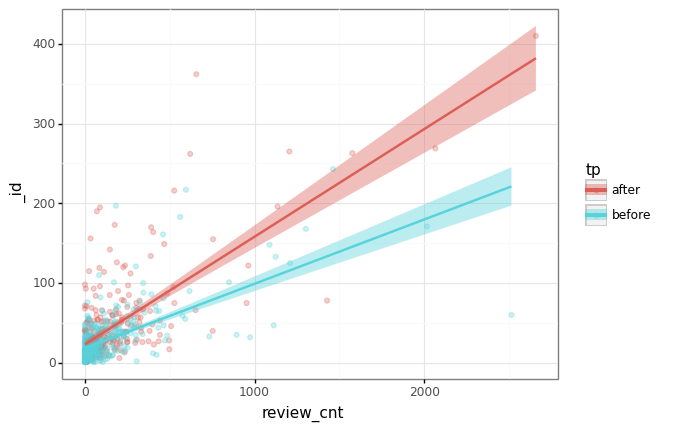

<ggplot: (8780513227894)>

In [12]:
(
    ggplot(data = pd.concat([before.assign(tp = "before"), after.assign(tp = "after")]).groupby(["tp", "slug", "review_cnt"])._id.count().reset_index(), mapping = aes(x = "review_cnt", y = "_id", color = "tp", fill = "tp")) +
    geom_point(alpha = 0.3) +
    geom_smooth(method = "lm") +
    theme_bw()
)

In [13]:
def corr_plot(df, color = "red") :
    
    print(df.groupby(["slug", "review_cnt", "visibleCloudType"])._id.count().reset_index().corr())
    tmp = (
        ggplot(data = df.groupby(["slug", "review_cnt", "visibleCloudType"])._id.count().reset_index(), mapping = aes(x = "review_cnt", y = "_id")) +
        geom_point(color = color, alpha = 0.3) +
        geom_smooth(color = color, method = "lm") +
        theme_bw()
    )
    
    print(tmp)
    
    return

- 후기뷰 별 상관관계
    - 위와 같이 상관계수별로 차이가 꽤 심한 것을 확인

- pearson

In [14]:
after[after.visibleCloudType == "normal"].groupby(["slug", "visibleCloudType", "review_cnt"])._id.count().reset_index().corr()

,review_cnt,_id
review_cnt,1.00,0.67
_id,0.67,1.00


In [15]:
after[after.visibleCloudType == "review-research"].groupby(["slug", "visibleCloudType", "review_cnt"])._id.count().reset_index().corr()

,review_cnt,_id
review_cnt,1.00,0.68
_id,0.68,1.00


In [16]:
after[after.visibleCloudType == "self-answer"].groupby(["slug", "visibleCloudType", "review_cnt"])._id.count().reset_index().corr()

,review_cnt,_id
review_cnt,1.00,0.17
_id,0.17,1.00


- spearman

In [17]:
after[after.visibleCloudType == "normal"].groupby(["slug", "visibleCloudType", "review_cnt"])._id.count().reset_index().corr(method = "spearman")

,review_cnt,_id
review_cnt,1.00,0.47
_id,0.47,1.00


In [18]:
after[after.visibleCloudType == "review-research"].groupby(["slug", "visibleCloudType", "review_cnt"])._id.count().reset_index().corr(method = "spearman")

,review_cnt,_id
review_cnt,1.00,0.36
_id,0.36,1.00


In [19]:
after[after.visibleCloudType == "self-answer"].groupby(["slug", "visibleCloudType", "review_cnt"])._id.count().reset_index().corr(method = "spearman")

,review_cnt,_id
review_cnt,1.00,0.58
_id,0.58,1.00


- 그래프를 확인해보면 셀프답변형은 애초에 후기수가 없는 변호사들만 선택하였고, 

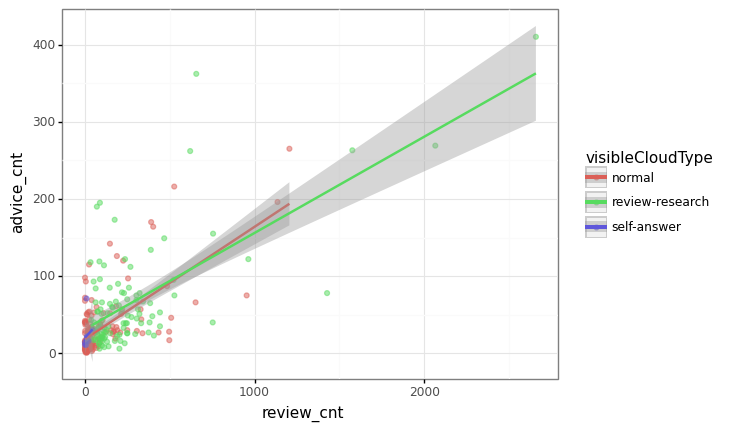

<ggplot: (8780480711930)>

In [20]:
(
    ggplot(data = after.groupby(["visibleCloudType", "slug", "review_cnt"])._id.count().reset_index().rename(columns = {"_id" : "advice_cnt"}), mapping = aes(x = "review_cnt", y = "advice_cnt", color = "visibleCloudType")) +
    geom_point(alpha = 0.5) +
    geom_smooth(method = "lm") +
    theme_bw()
)

- 리뷰 수 별 후기뷰 선택지에 대한 히스토그램을 그려보면 아래와 같음.
    - 후기가 많은 변호사들은 대부분 분석형을 선택
    - 중간층에 대해서 혼용을 하고 있음.
        - 강조태그와도 비슷한 이치로, 아무리 소프트보딩을 위한 아이템을 만든들... 상위권 광고주들이 열심히 사용해서 가져가버리는 듯한 느낌이....

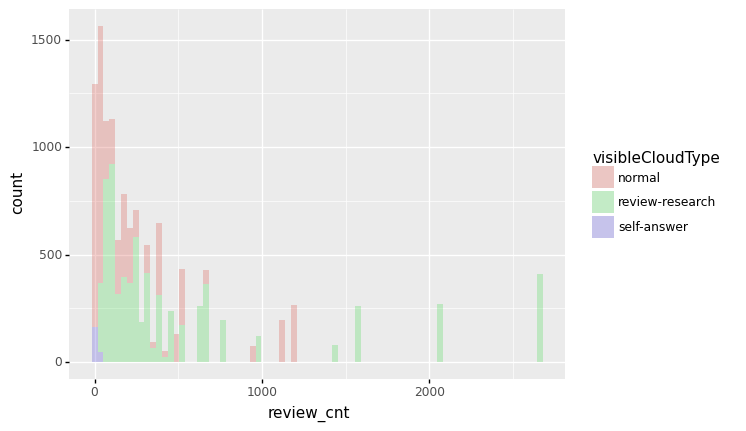

<ggplot: (8780480699308)>

In [21]:
(
    ggplot() +
    geom_histogram(data = after, mapping = aes(x = "review_cnt", fill = "visibleCloudType"), alpha = 0.3)
)

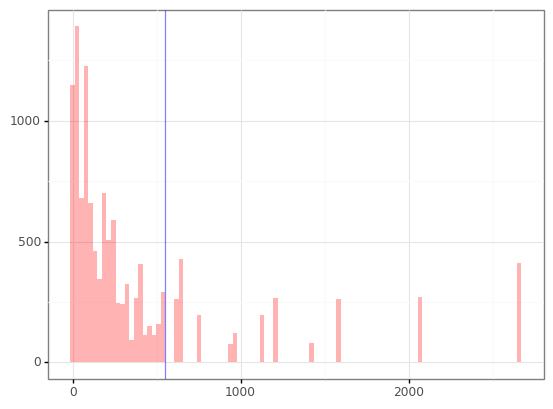

<ggplot: (8780477783031)>

In [31]:
(
    ggplot(data = after) +
    geom_histogram(mapping = aes(x = "review_cnt"), bins = 100, fill = "red", alpha = 0.3) +
    geom_vline(xintercept = 550, color = "blue", alpha = 0.5) +
    theme_bw() +
    theme(axis_title = element_blank())
)

In [23]:
def corr_for_quantiles(a, b, method = None) :
    if method == None :
        smooth = geom_smooth()
    else :
        smooth = geom_smooth(method = method)
    plot = (
        ggplot(data = after[(after.review_cnt.between(a, b))].groupby(["visibleCloudType", "slug", "review_cnt"])._id.count().reset_index().rename(columns = {"_id" : "advice_cnt"}), mapping = aes(x = "review_cnt", y = "advice_cnt", color = "visibleCloudType")) +
        geom_point(alpha = 0.5) +
        smooth +
        theme_bw()
    )    
    
    print(plot)
    
    return

In [24]:
after.review_cnt.describe([(i+1) * 0.1 for i in range(10)])

count   12675.00
mean    409.77  
std     592.81  
min     0.00    
10%     17.00   
20%     39.00   
30%     81.00   
40%     119.00  
50%     188.00  
60%     252.00  
70%     388.00  
80%     620.00  
90%     1205.00 
100%    2658.00 
max     2658.00 
Name: review_cnt, dtype: float64

- 후기뷰가 50개 이상 80% 이하인 변호사의 후기 - 상담 분포도

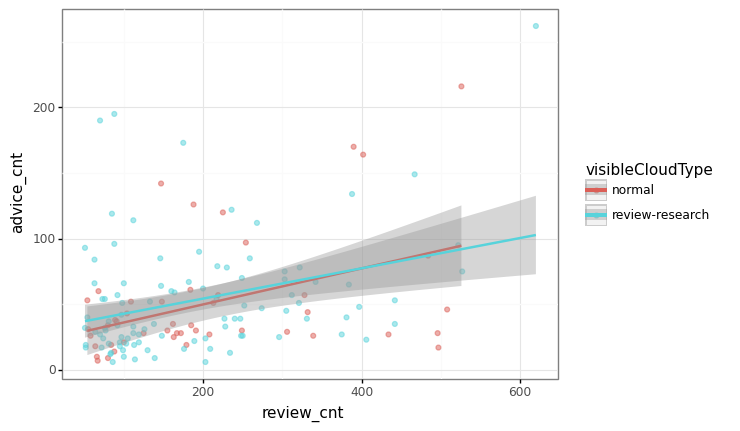

In [33]:
corr_for_quantiles(50, 620, "lm")

- 후기뷰가 50개 이상 변곡점(?!) 이하인 변호사의 후기 - 상담 분포도

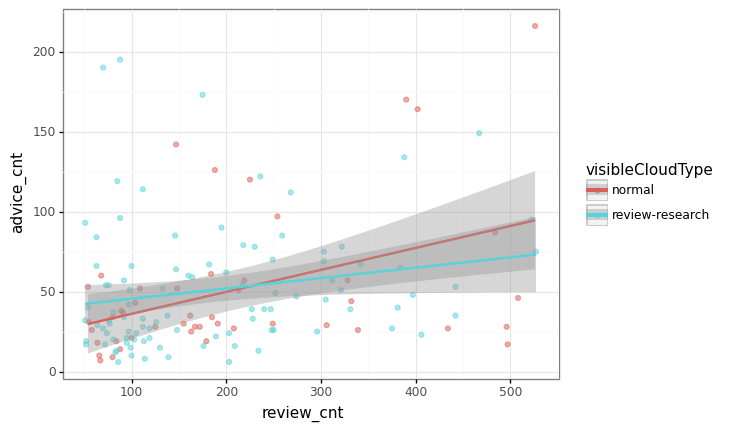

In [32]:
corr_for_quantiles(50, 550, "lm")